In [28]:
%pip install hydra-core
%pip install pmdarima
%pip install sktime
%pip install xlrd

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
import sagemaker

import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.seasonal import STL

from hydra import compose, initialize, core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [24]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='eda')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

In [25]:
print(config['raw_data_url'])

https://www.eia.gov/dnav/pet/hist_xls/WGFUPUS2w.xls


In [26]:
!wget -q {config['raw_data_url']} -O gas_data.xls

In [31]:
gas_data = pd.read_excel(
    'gas_data.xls',
    sheet_name='Data 1',
    header=2, # The column names start on the 3rd row
    index_col='Date'
)

gas_data.columns = ['gas_product']

gas_data.shape

(1740, 1)

In [32]:
assert gas_data['gas_product'].isna().sum() == 0
assert gas_data.index.duplicated(keep=False).sum() == 0

In [33]:
print("try to forecast the next 6 months of gas products")

try to forecast the next 6 months of gas products


In [34]:
train, test = pm.model_selection.train_test_split(gas_data, test_size=config['forecast_horizon'])
print(f'The training period is {train.index.min().strftime("%Y-%m-%d")} to {train.index.max().strftime("%Y-%m-%d")}')
print(f'The test period is {test.index.min().strftime("%Y-%m-%d")} to {test.index.max().strftime("%Y-%m-%d")}')

The training period is 1991-02-08 to 2023-12-08
The test period is 2023-12-15 to 2024-06-07


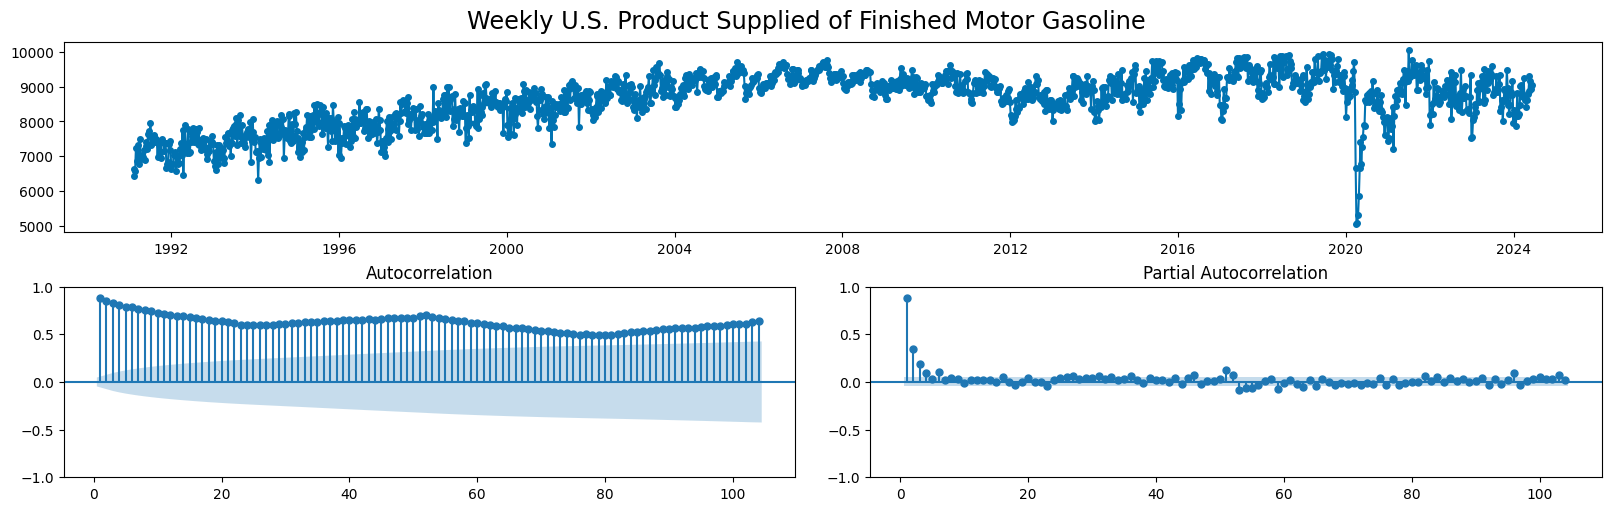

In [35]:
lags = np.min([2 * (365.25 / 7), (gas_data.shape[0] / 5)])

fig, ax = plot_correlations(
    series=gas_data,
    lags=lags,
    zero_lag=False,
    suptitle='Weekly U.S. Product Supplied of Finished Motor Gasoline'
)
fig.set_size_inches((16, 5))
plt.show()

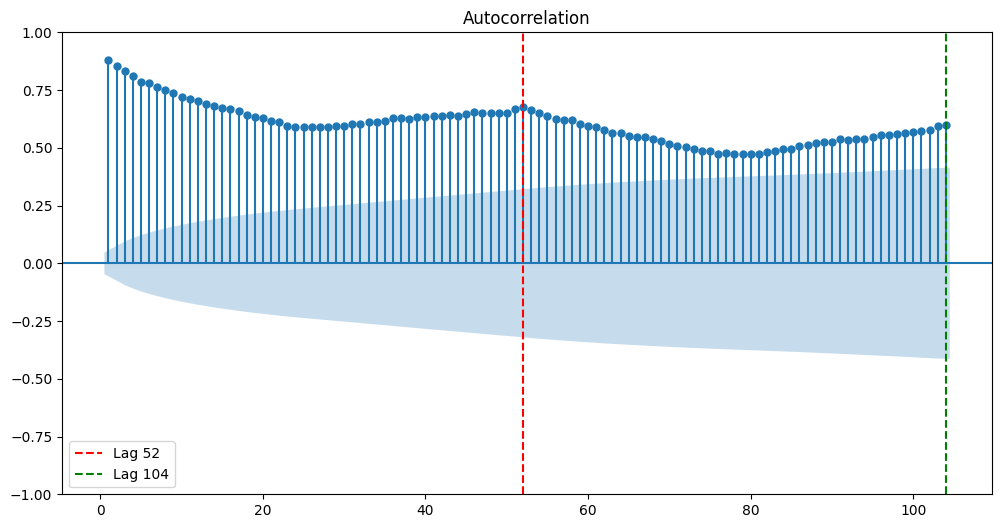

In [36]:
fig = plot_acf(
    x=gas_data, 
    lags=lags,
    zero=False
)
fig.set_size_inches(12, 6)
plt.axvline(x=52, color='r', linestyle='--', label='Lag 52')
plt.axvline(x=104, color='g', linestyle='--', label='Lag 104')
plt.legend()
plt.show();

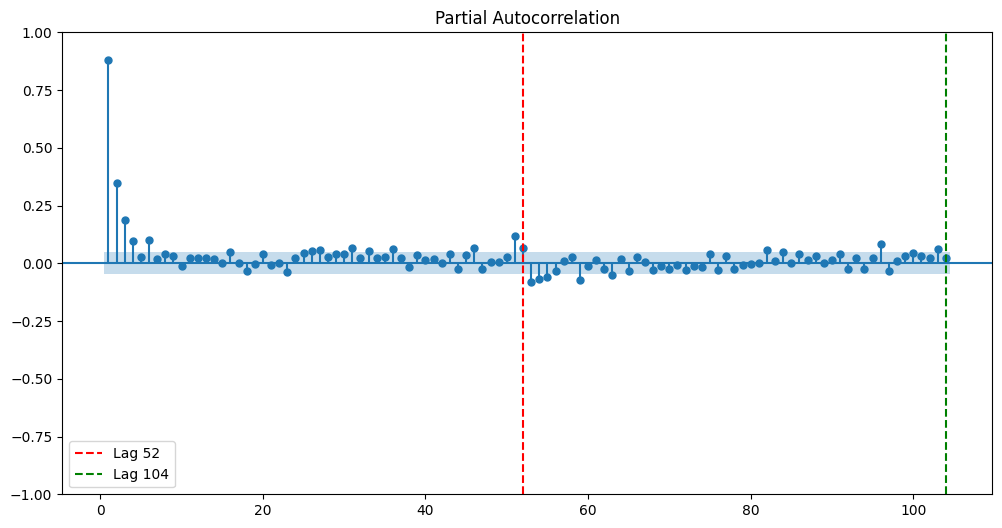

In [37]:
fig = plot_pacf(
    x=gas_data, 
    lags=lags,
    zero=False
)
fig.set_size_inches(12, 6)
plt.axvline(x=52, color='r', linestyle='--', label='Lag 52')
plt.axvline(x=104, color='g', linestyle='--', label='Lag 104')
plt.legend()
plt.show();

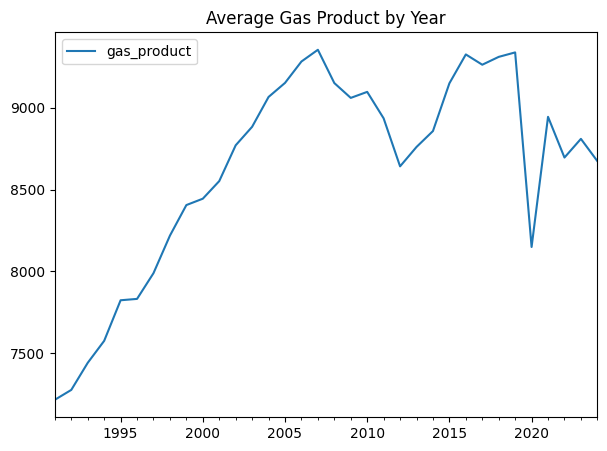

In [38]:
gas_data.resample('YS').mean().plot(y='gas_product', figsize=(7, 5), title='Average Gas Product by Year');

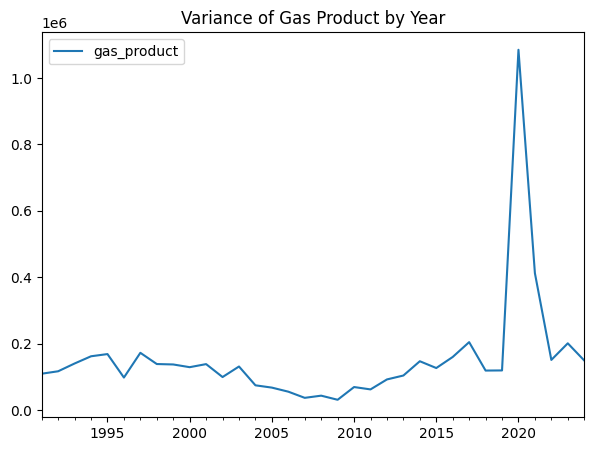

In [39]:
gas_data.resample('YS').var().plot(y='gas_product', figsize=(7, 5), title='Variance of Gas Product by Year');

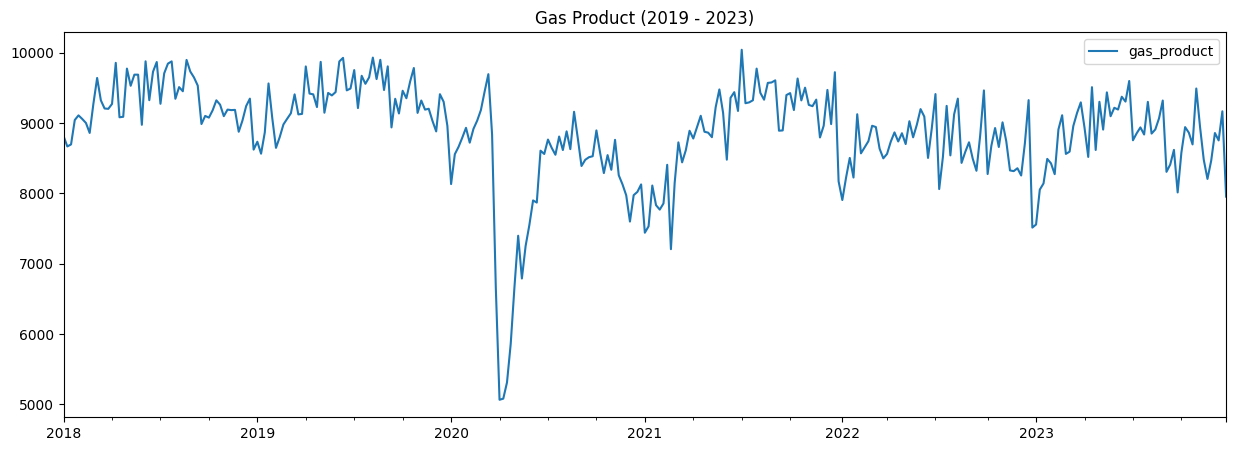

In [40]:
gas_data.loc['2018':'2023'].plot(figsize=(15, 5), title='Gas Product (2019 - 2023)');

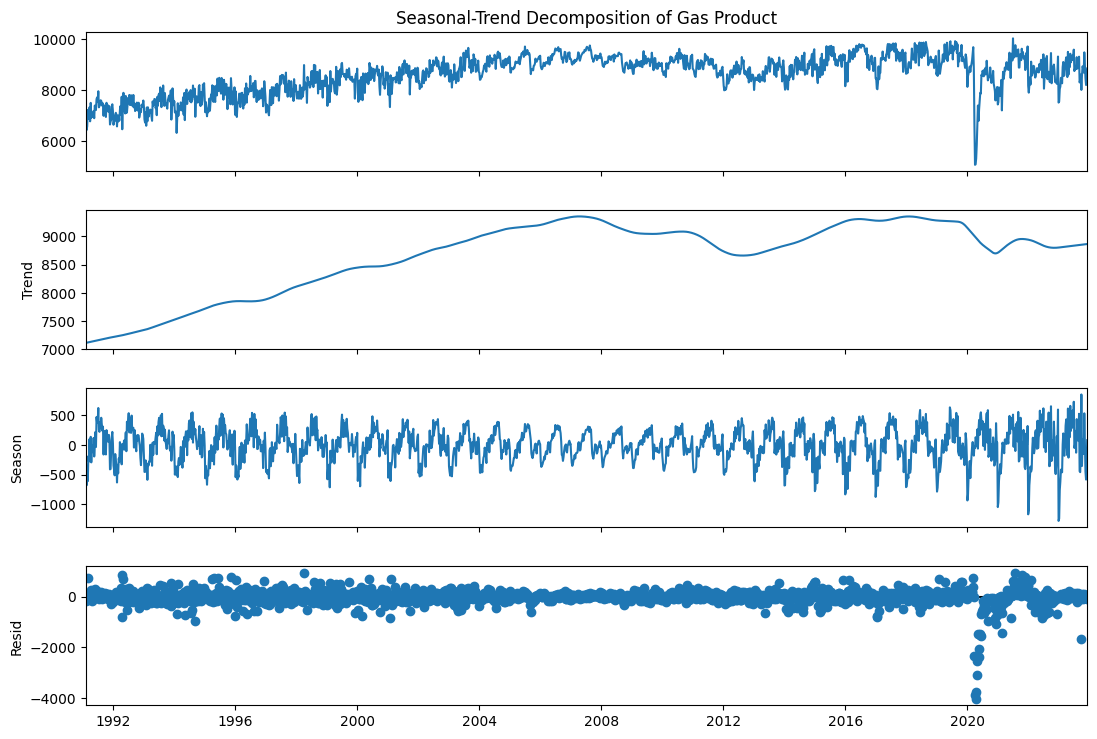

In [41]:
m = (365.25 / 7)
decomp_result = STL(endog=pd.Series(train['gas_product'], name='Seasonal-Trend Decomposition of Gas Product'), period=int(np.floor(m)), robust=True).fit()
fig = decomp_result.plot()
fig.set_size_inches(12, 8)
plt.show();

In [42]:
resid_75 = np.quantile(decomp_result._resid, 0.75)
resid_25 = np.quantile(decomp_result._resid, 0.25)
resid_iqr = resid_75 - resid_25

# Indices of outliers
outlier_indices = np.logical_or((decomp_result._resid > resid_75 + 3 * resid_iqr), (decomp_result._resid < resid_25 - 3 * resid_iqr))
outlier_indices.sum()

45

In [43]:
earliest = train.loc[(outlier_indices)].loc['2020'].index.min().strftime('%Y-%m-%d')
latest = train.loc[(outlier_indices)].index.max().strftime('%Y-%m-%d')
print(f'The outlier with the earliest date within the COVID-19 years is {earliest}')
print(f'The outlier with the latest date within the COVID-19 years is {latest}')

The outlier with the earliest date within the COVID-19 years is 2020-03-13
The outlier with the latest date within the COVID-19 years is 2023-09-29


In [44]:
train['covid_forecast'] = np.logical_and((train.index >= earliest), (train.index <= latest))
test['covid_forecast'] = False

In [45]:
# Save the outlier indices to the current directory
pd.concat([train, test], axis=0).to_csv('gas_data.csv', index=True)

# Upload both the raw data and the outlier indices to s3
sagemaker.s3.S3Uploader.upload('gas_data.csv', f's3://{config["s3_bucket"]}/{config["s3_key"]}/raw-data')

# Remove from the current directory
os.remove('gas_data.csv')
os.remove('gas_data.xls')